In [63]:
#Sentiment analysis using Stanford's Amazon Fine Foods (> 5 million values) reviews and Dask
# https://snap.stanford.edu/data/web-FineFoods.html

# Main Question:
# Can we classify the Amazon Reviews as positive or negative based on the review text? 

#The analysis is broken into several stages:
# 1) Data cleaning and pre-processing
# 2) Natural Language Processing (Tokenization) and Binary Vectorization
# 3) Modelling (Logistic Regression, Bagged Decision Trees, Random Forests)
# 4) Discussion

# Overall - Random Forest classification was able to achieve an almost 90% classification score
# using the top-100 tokens from the review texts

In [ ]:
################################
######## DATA IMPORTING ########
################################

In [ ]:
#Data was encoded uses cp1252 and not the default UTF-8
raw_data = bag.read_text('finefoods.txt', encoding = 'cp1252')


In [12]:
##################################################
########## DATA CLEANING/PRE-PROCESSING ##########
##################################################

In [ ]:
#Now need to find a way to add structure to the data and to 
# differentiate the different reviews - here we can use the '\n\n' as the delimiter.

# We then parse the datafile, looking for the delimiter, but without reading the whole file into memory.
# We will use the file iterator to look at small chunks with a set buffer size

from dask.delayed import delayed

def get_next_part(file, start_index, span_index = 0, blocksize = 1000):
    file.seek(start_index)
    buffer = file.read(blocksize + span_index).decode('cp1252') # decodes bytes to string
    delimiter_position = buffer.find('\n\n')
    if delimiter_position == -1:
        return get_next_part(file, start_index, span_index + blocksize)
    else:
        file.seek(start_index)
        return start_index, delimiter_position

In [3]:
# Here we read through the file and use get_next_part to find each review

#Output is a list of tuples - number of bytes to read after the starting byte

with open('finefoods.txt', 'rb') as file_handle:
    size = file_handle.seek(0,2) - 1 # size of the file
    more_data = True
    output = []
    current_position = next_position = 0
    while more_data:
        if current_position >= size:
            more_data = False
        else:
            current_position, next_position = get_next_part(file_handle, current_position, 0)
            output.append((current_position, next_position)) # next position is the delimiter_position
            current_position = current_position + next_position + 2 #delimiter is 2 bytes

In [4]:
# Now need to take the review address (start byte and length of bytes) and match them to the reviews
# Will use Dask bags to divide up the reviews to multiple workers
# Since reviews are stored as JSON, dictionary objects for each review will be created 

def get_item(filename, start_index, delimiter_position, encoding = 'cp1252'):
    with open(filename, 'rb') as file_handle:
        file_handle.seek(start_index)
        text = file_handle.read(delimiter_position).decode(encoding)
        elements = text.strip().split('\n')
        key_value_pairs = [(element.split(': ')[0], element.split(': ')[1])
                          if len(element.split(': ')) > 1
                          else ('unknown', element)
                          for element in elements]
        return dict(key_value_pairs)


# Combines the output addresses with the get_item function to access the reviews
reviews = bag.from_sequence(output).map(lambda x: get_item('finefoods.txt', x[0], x[1]))

In [5]:
# The last step preprocessing step before binary vectorization is to tag the
# reviews as being either positive or negative based on review scores

def tag_positive_negative_by_score(element):
    if float(element['review/score']) > 3:
        element['review/sentiment'] = 'positive'
    else:
        element['review/sentiment'] = 'negative'
    return element

tagged_reviews = reviews.map(tag_positive_negative_by_score)


In [13]:
#################################################################
############### IMPLEMENTING BINARY VECTORIZATION ###############
#################################################################

In [ ]:
#Binary vectorization - presence or absence of words (0 or 1)
# First need to apply tooks from the NLTK for tokenization and removing stopwords

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from functools import partial

tokenizer = RegexpTokenizer(r'\w+') #only words

def extract_reviews(element): # isolate review text and make sure it is lower case
    element['review/tokens'] = element['review/text'].lower()
    return element

def tokenize_reviews(element): #creates tokens from text
    element['review/tokens'] = tokenizer.tokenize(element['review/tokens'])
    return element

def filter_stopword(word, stopwords): # filter to check for stopwords
    return word not in stopwords

def filter_stopwords(element, stopwords): #drops stopwords 
    element['review/tokens'] = list(filter(partial(filter_stopword,
                                                 stopwords = stopwords), element['review/tokens']))
    return element

stopword_set = set(stopwords.words('english'))
more_stopwords = {'br', 'amazon', 'com', 'http', 'www', 'href', 'gp'} # adds extra stop words
all_stopwords = stopword_set.union(more_stopwords)

review_extracted_text = tagged_reviews.map(extract_reviews)

review_tokens = review_extracted_text.map(tokenize_reviews)
review_text_clean = review_tokens.map(partial(filter_stopwords, stopwords = all_stopwords))


In [8]:
#Counting the number of tokens
def extract_tokens(element):
    return element['review/tokens']

extracted_tokens = review_text_clean.map(extract_tokens)

unique_tokens = extracted_tokens.flatten().distinct()

number_of_tokens = unique_tokens.count().compute()

number_of_tokens

#We have 114290 unique words

114290

In [9]:
from dask.diagnostics import ProgressBar

#Will use the top 100 words for the binary vectorization - models could be improved with more
# but would take substantial computing time

def count(accumulator, element):
    return accumulator + 1 #counts the instances of each word

def combine(total_1, total_2):
    return total_1 + total_2 # combines the same word across partitions

with ProgressBar():
    token_counts = extracted_tokens.flatten().foldby(lambda x: x, count, 0, combine, 0).compute()
    top_tokens = sorted(token_counts, key = lambda x: x[1], reverse = True)
    top_100_tokens = list(map(lambda x: x[0], top_tokens[:100]))

[########################################] | 100% Completed |  1min 21.6s


In [10]:
#Now search through the reviews to see if they contain any of the tokens
# by applying binary vectorization

import numpy as np

def vectorize_tokens(element):
    vectorized_tokens = np.where(np.isin(top_100_tokens, element['review/tokens']),
                                1, 0)
    element['review/token_vector'] = vectorized_tokens
    return element

def prep_model_data(element):
    return {'target': 1 if element['review/sentiment'] == 'positive' else 0,
           'features': element['review/token_vector']}

model_data = review_text_clean.map(vectorize_tokens).map(prep_model_data)


In [ ]:
#Now need to take the bag and transform it into an array that can be used by ML

from dask import array as dask_array

def stacker(partition):
    return dask_array.concatenate([element for element in partition])

with ProgressBar():
    feature_arrays = model_data.pluck('features').map(lambda x: dask_array.from_array(x, 1000).reshape(
    1, -1)).reduction(perpartition = stacker, aggregate = stacker)
    feature_array = feature_arrays.compute()
    

In [ ]:
# Now we want to save all of the above data manipulation and transformation
# as chunks in .zarr files 

with ProgressBar():
    #This saves the array
    feature_array.rechunk(5000).to_zarr('sentiment_feature_array.zarr')
    
    #Calls back the feature array
    feature_array = dask_array.from_zarr('sentiment_feature_array.zarr')
    
with ProgressBar():
    target_arrays = model_data.pluck('target').map(lambda x: dask_array.from_array(x, 1000).reshape(
    1, -1)).reduction(perpartition = stacker, aggregate = stacker)
    
    #Saves the target array
    target_arrays.compute().rechunk(5000).to_zarr('sentiment_target_array.zarr')
    
    #Calls back the target array
    target_array = dask_array.from_zarr('sentiment_target_array.zarr')

In [4]:
################################################
############## RUNNING THE MODELS ##############
################################################

In [ ]:
# If starting notebook after binary vectorization - can load files here

from dask import array as dask_array

feature_array = dask_array.from_zarr('sentiment_feature_array.zarr')
target_array = dask_array.from_zarr('sentiment_target_array.zarr')

In [5]:
#First step is dividing the dataset in to training and testing sets
# Train_test_split defaults to splitting 80% training and 20% testing

from dask_ml.model_selection import train_test_split

X = feature_array
y = target_array.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [67]:
###############################################
###### First Model - Logistic Regression ######
###############################################

In [ ]:
#First we run a basic logic regression model with default parameters
# and also use StandardScaler to scale the inputs
# The most efficent way to do both is by using a pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), LogisticRegression())


clf_fit = clf.fit(X_train, y_train) 

In [47]:
# Examining the test set score - we find that the basic logistic regression model
# results in an 80% correct classification score for the reviews

clf_fit.score(X_test, y_test)

#This will serve as the baseline for the next set of models that we run to try and improve this score.

/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


0.7957991767230764

In [ ]:
# To improve on the baseline logistic regression model - will tune the hyperparameters using
# GridSearchCV

from sklearn.model_selection import GridSearchCV

#Specifying the parameters to tune - two different penalty terms, different C values (penalty tuning parameter),
# and three different solvers - the default lbfgs, liblinear, and saga.
parameters = {'logisticregression__penalty': ['l1', 'l2'], 
              'logisticregression__C': [.5, 1, 2],
             'logisticregression__solver': ['liblinear', 'saga', 'lbfgs']}

clf = make_pipeline(StandardScaler(), LogisticRegression())

tuned_clf = GridSearchCV(clf, parameters) #search across all of the parameters after scaling


tuned_clf_fit = tuned_clf.fit(X_train, y_train)


In [ ]:
# Using cv_results_ - we can see the full results of the GridSearchCV including rank_test_score

#What we can see is the best estimator (also accessible as .best_estimator_) has
# the parameters: C = 0.5, penalty = 'l1', and solver = 'saga'

pd.DataFrame(tuned_clf_fit.cv_results_)

tuned_best_lr = tuned_clf_fit.best_estimator_

# Will then used this best_estimator to run the test sets

In [57]:
# Results from the tuned linear regression found almost no change - essentially the same result
# 79.57%
tuned_best_lr.score(X_test, y_test)

/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


0.7957639939485628

In [62]:
# pickling the model so it can be used again 

import dill

with open('FullLRTuned.pkl', 'wb') as file:
    dill.dump(tuned_clf_fit, file)

In [ ]:
#####################################################
########### SECOND MODEL - DECISION TREES ###########
#####################################################

In [8]:
# Hoping to improve on the classification score from the logistic model
# we are now using a Decision Trees Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import DistanceMetric

#Here there is no need to use StandardScaler() as 
# decision trees do not have the same need for standardized inputs 

tree_model = DecisionTreeClassifier(criterion='gini', #using gini criterion
                                   random_state = 1)

tree_model_fit = tree_model.fit(X_train, y_train)

In [18]:
#When we run the fitted model with the test set - we see an improved classification
# score over what we found with the logistic regression: 81%

#Not a huge improvement but is a slight one

tree_model.score(X_test, y_test)

0.8144460472152834

In [19]:
# One way to examine the variance and fit of the model is to see the difference
# in the test and train scores

from sklearn.metrics import accuracy_score

tree_y_train_pred = tree_model.predict(X_train)
tree_y_test_pred = tree_model.predict(X_test)

tree_train = accuracy_score(y_train, tree_y_train_pred)
tree_test = accuracy_score(y_test, tree_y_test_pred)

print('Decision train/test accuracies %.3f/%.3f' %(tree_train, tree_test))

#What we see is a split between train accuracy and test accuracy suggesting fairly strong
# overfitting: 97% vs 81%

Decision train/test accuracies 0.979/0.814


In [23]:
# We can attempt to adjust for the overfitting by tuning the depth of the trees
# as well as the criterion used

from sklearn.tree import DecisionTreeClassifier

param = {'max_depth': [2, 3, 4, 5, 10, 15, 20, 30, 40],
        'criterion': ['gini', 'entropy']}

tree = DecisionTreeClassifier(random_state = 1)

tree_search = GridSearchCV(tree, param)

tree_search_fit = tree_search.fit(X_train, y_train)

In [24]:
tree_search_fit.score(X_test, y_test)

0.8159413151321113

In [25]:
#Best estimator is gini criterion with a max depth of 40
tree_model_best = tree_search_fit.best_estimator_

# Examining the train/test accuracy similar to above
tree_y_train_pred = tree_model_best.predict(X_train)
tree_y_test_pred = tree_model_best.predict(X_test)

tree_train = accuracy_score(y_train, tree_y_train_pred)
tree_test = accuracy_score(y_test, tree_y_test_pred)

print('Decision train/test accuracies %.3f/%.3f' %(tree_train, tree_test))

# Tuning the parameters did not seem to make a huge difference to the 
# train/test accuracies - still appears overfit 

Decision train/test accuracies 0.923/0.816


In [27]:
#One final approach to see if we can improve our fit is by using
# bagged trees approach with bootstrap resampling

from sklearn.ensemble import BaggingClassifier

tree_bag = BaggingClassifier(base_estimator= tree_model_best, n_estimators=100, #100 trees
                              max_samples=1.0, max_features = 1.0, bootstrap=True,
                              bootstrap_features=False, n_jobs = -1, random_state=1)

tree_bag_fit = tree_bag.fit(X_train, y_train)

In [28]:
tree_y_train_pred = tree_bag_fit.predict(X_train)
tree_y_test_pred = tree_bag_fit.predict(X_test)

tree_train = accuracy_score(y_train, tree_y_train_pred)
tree_test = accuracy_score(y_test, tree_y_test_pred)

print('Bagged decision tree train/test accuracies %.3f/%.3f' %(tree_train, tree_test))

#Similar to above, we compared the train/test accuracies and find a marked improvement both
# in classification score and in the fitting. Much less overfit

Bagged decision tree train/test accuracies 0.942/0.856


In [34]:
#An additional way to visualize the accuracy and bias of the model is by plotting the validation
# curve

import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

param_range = [2, 3, 4, 5, 10, 15, 20, 30, 40]

pipe_tree = make_pipeline(DecisionTreeClassifier(random_state = 1))

train_scores, test_scores = validation_curve(
    estimator = pipe_tree,
    X = X_train,
    y = y_train,
    param_name = 'decisiontreeclassifier__max_depth',
    param_range = param_range,
    cv = 5)

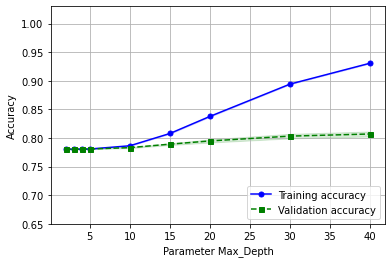

In [36]:
import numpy as np

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean, color = 'blue', marker = 'o',
        markersize = 5, label = 'Training accuracy')

plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color = 'blue')

plt.plot(param_range, test_mean,
        color = 'green', linestyle = '--',
        marker = 's', markersize = 5,
        label = 'Validation accuracy')

plt.fill_between(param_range, test_mean + test_std,
                test_mean - test_std,
                alpha = 0.15, color = 'green')

plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Parameter Max_Depth')
plt.legend(loc = 'lower right')
plt.ylim([0.65, 1.03])
plt.show()

#What we can see is that as the depth increases - the accuracy does not necessary
# increase but the divide between training and test does increase.

In [38]:
# The current best model though is the bagged decision tree: 85% accuracy
with open('BaggedDecisionTree.pkl', 'wb') as file:
    dill.dump(tree_bag_fit, file)

In [ ]:
#####################################################
############ THIRD MODEL - RANDOM FOREST ############
#####################################################

In [40]:
from sklearn.ensemble import RandomForestClassifier
from dask.diagnostics import ProgressBar

# To try and further improve on the classification score of the the bagged
# decision trees - we'll use a Random Forest classifier

#setting up the parameters to be searched
param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': [20, 30, 40, 50]}

forest = RandomForestClassifier(n_estimators=25,
                               random_state=1,
                               n_jobs = -1)

forest_search = GridSearchCV(forest, param_grid)

with ProgressBar():
    forest_search.fit(X_train, y_train)

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.5s


In [43]:
#The best estimator found has a max depth of 50 and gini criterion
forest_best = forest_search.best_estimator_

RandomForestClassifier(max_depth=50, n_estimators=25, n_jobs=-1, random_state=1)

In [62]:
forest_y_train_pred = forest_best.predict(X_train)
forest_y_test_pred = forest_best.predict(X_test)

forest_train = accuracy_score(y_train, forest_y_train_pred)
forest_test = accuracy_score(y_test, forest_y_test_pred)

print('Random Forest train/test accuracies %.3f/%.3f' %(forest_train, forest_test))

# What we find when we compare the train and test accuracies is similar to what was 
# found with the bagged forest - better convergence between the test and training sets

# We also see an improved classification score but not a significant improvement: 86.4%

Random Forest train/test accuracies 0.958/0.864


In [ ]:
# Pickling the the fit random forest model
with open("Random_Forest_fit", "wb") as file:
    dill.dump(forest_best, file)

In [48]:
# Another approach for finding the best classification model for the sentiment analysis
# is to instead run all three of the models using cross_val_score

#Cross_val_score trains the models with a k-fold (here cv = 5) cross validation and
# provides a scoring (here scoring = 'roc_auc')

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

clf1 = LogisticRegression(solver = 'saga', penalty = 'l1', C = 0.5)

clf2 = BaggingClassifier(base_estimator= tree_model_best, n_estimators=100, #100 trees
                              max_samples=1.0, max_features = 1.0, bootstrap=True,
                              bootstrap_features=False, n_jobs = -1, random_state=1)

clf3 = RandomForestClassifier(criterion= 'gini',
                              max_depth=50,
                               n_estimators=25,
                               random_state=1,
                               n_jobs = -1)

pipe1 = Pipeline([['sc', StandardScaler()], 
                   ['lr', clf1]])

clf_labels = ['Logistic Regression', 'BaggedTrees','Random Forest']
print('5-fold cross validation')
for clf, label in zip([pipe1, clf2, clf3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X = X_train,
                            y = y_train,
                            cv = 5,
                            scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

5-fold cross validation


/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a futu

ROC AUC: 0.77 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.01) [BaggedTrees]
ROC AUC: 0.88 (+/- 0.01) [Random Forest]


In [ ]:
########################################
############## DISCUSSION ##############
########################################

In [ ]:
#The result of the above comparison between classification models shows that Random Forest has the best 
# ROC/AUC score which corresponds with the better classification score for Random Forest as well.

# Overall, the use of the top-100 tokens created via binary vectorization was able to 
# correctly classify the sentiments of the amazon fine food reviews for 87-88% of the reviews.

# This highlights the utility of NLP for sentiment analysis as well as the strength of random forests as a 
# classifier

# Using more than the top-100 tokens (say the top-1000) could potentially improve on the current classification
# score